### Bayesian Semantic Segmentation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
import tensorflow as tf
import tensorflow.contrib.slim as slim
from utils import unpool_with_argmax
%matplotlib inline

In [2]:
train_file = 'CamVid/train.txt'
val_file = 'CamVid/val.txt'
test_file = 'CamVid/test.txt'

In [3]:
IMAGE_HEIGHT = 72
IMAGE_WIDTH = 96
IMAGE_DEPTH = 3
NUM_CLASSES = 12
TRAIN_BATCH_SIZE=32
VAL_BATCH_SIZE=TRAIN_BATCH_SIZE
TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
NUM_ITERS = 2000
NUM_TRAIN = 367
NUM_VAL = 101
NUM_TEST = 233

In [16]:
def get_label_colors():
    Sky = [128,128,128]
    Building = [128,0,0]
    Pole = [192,192,128]
    Road_marking = [255,69,0]
    Road = [128,64,128]
    Pavement = [60,40,222]
    Tree = [128,128,0]
    SignSymbol = [192,128,128]
    Fence = [64,64,128]
    Car = [64,0,128]
    Pedestrian = [64,64,0]
    Bicyclist = [0,128,192]
    Unlabelled = [0,0,0]

    label_colors = np.array([Sky, Building, Pole, Road, Pavement, Tree, SignSymbol, 
                             Fence, Car, Pedestrian, Bicyclist, Unlabelled])
    return label_colors

def img_annot_to_rgb(img_annot):
    r = img_annot.copy()
    g = img_annot.copy()
    b = img_annot.copy()
    label_colors = get_label_colors()
    for i in range(len(label_colors)):
        r[img_annot==i]=label_colors[i,0]
        g[img_annot==i]=label_colors[i,1]
        b[img_annot==i]=label_colors[i,2]
    return np.stack([r,g,b],axis=2)/255.0

def visualize_image_annot(img_data, annot_data, predicted_annot=None):
    if predicted_annot is None:
        fig, ax = plt.subplots(1,2,figsize=(10,12))
        ax[0].imshow(img_data)
        ax[0].set_title('Original Image')
        ax[1].imshow(img_annot_to_rgb(annot_data))
        ax[1].set_title('True Segmentation')
        plt.show()
    else:
        fig, ax = plt.subplots(1,3,figsize=(10,12))
        ax[0].imshow(img_data)
        ax[0].set_title('Original Image')
        ax[1].imshow(img_annot_to_rgb(predicted_annot))
        ax[1].set_title('Predicted Segmentation')
        ax[2].imshow(img_annot_to_rgb(annot_data))
        ax[2].set_title('True Segmentation')
        plt.show()

def bayes_visualize_image_annot(img_data, annot_data, predicted_annot, ax, n_samples=20):
    ax[0].imshow(img_data)
    ax[0].set_title('Original Image')
    if n_samples ==1:
        alpha = 1.0
    else:
        alpha = 1.5/n_samples
    ax[1].imshow(img_annot_to_rgb(predicted_annot), alpha=alpha)
    ax[1].set_title('Posterior Predicted Segmentation %d samples' % n_samples)
    ax[2].imshow(img_annot_to_rgb(annot_data))
    ax[2].set_title('True Segmentation')
    ax[0].grid(False)
    ax[1].grid(False)
    ax[2].grid(False)
    #plt.show()

def plot_uncertainity_from_posterior(ppc_samples, image_idx, n_samples):
    height, width = ppc_samples.shape[2], ppc_samples.shape[3]
    diff = np.zeros((height,width))
    for i in range(n_samples-1):
        diff += np.abs(ppc_samples[i,image_idx,:,:] - ppc_samples[i+1,image_idx,:,:])
    fig, ax = plt.subplots(1,1)
    ax.imshow(diff, cmap='viridis')
    ax.grid(False)
    ax.set_title("Prediction Uncertainity - Heatmap")
    plt.show()

In [5]:
def load_data(file, train=True, batch_size=10, labels=True):
    def _load_image(filename):
        image_string = tf.read_file(filenames[0])
        image_decoded = tf.image.decode_png(image_string, channels=3)
        image_decoded = tf.image.convert_image_dtype(image_decoded,tf.float32)
        return image_decoded

    def _load_image_with_labels(filenames):
        image_string = tf.read_file(filenames[0])
        image_decoded = tf.image.decode_png(image_string, channels=3)
        image_decoded = tf.image.convert_image_dtype(image_decoded,tf.float32)
        image_decoded = tf.image.resize_images(image_decoded, [IMAGE_HEIGHT, IMAGE_WIDTH])
        annot_string = tf.read_file(filenames[1])
        annot_decoded = tf.image.decode_png(annot_string, channels=1)
        annot_decoded = tf.image.resize_images(annot_decoded, [IMAGE_HEIGHT,IMAGE_WIDTH])
        annot_decoded = tf.squeeze(annot_decoded,axis=2)
        annot_decoded = tf.cast(annot_decoded, tf.int64)
        return image_decoded, annot_decoded

    dataset = tf.contrib.data.Dataset.from_tensor_slices(tf.constant([file]))
    dataset =  dataset.flat_map(lambda filename: tf.contrib.data.TextLineDataset(filename))
    dataset = dataset.map(lambda line: tf.string_split([line], delimiter=' ').values)
    if labels:
        dataset = dataset.map(_load_image_with_labels)
    else:
        dataset = dataset.map(_load_image)
    if train is True:
        dataset = dataset.shuffle(buffer_size=batch_size*3)
    dataset = dataset.batch(batch_size=batch_size)
    iterator = dataset.make_initializable_iterator()
    return iterator

In [6]:
tf.reset_default_graph()
train_iterator = load_data(train_file, batch_size=TRAIN_BATCH_SIZE)
val_iterator = load_data(val_file, train=False, batch_size=TRAIN_BATCH_SIZE)
test_iterator = load_data(test_file, train=False, batch_size=TRAIN_BATCH_SIZE)

## Probabilistic Approach

## 1. MODEL

In [7]:
import edward as ed
from edward.models import Categorical, Normal

In [8]:
inputs = tf.placeholder(tf.float32, [TRAIN_BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH ])
labels = tf.placeholder(tf.int32,[TRAIN_BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH])
is_training = tf.placeholder(tf.bool)

In [9]:
def model(inputs_, is_training):
    conv1_w = Normal(loc=tf.zeros([3,3,3,64]), scale=tf.ones([3,3,3,64]))
    conv1_b = Normal(loc=tf.zeros([64]), scale=tf.ones([64]))
    net = tf.nn.conv2d(inputs,conv1_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv1_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg1 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    
    conv2_w = Normal(loc=tf.zeros([3,3,64,128]), scale=tf.ones([3,3,64,128]))
    conv2_b = Normal(loc=tf.zeros([128]), scale=tf.ones([128]))
    net = tf.nn.conv2d(net,conv2_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv2_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg2 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    conv3_w = Normal(loc=tf.zeros([3,3,128,256]), scale=tf.ones([3,3,128,256]))
    conv3_b = Normal(loc=tf.zeros([256]), scale=tf.ones([256]))
    net = tf.nn.conv2d(net,conv3_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv3_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg3 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    net = unpool_with_argmax(net, arg3, name='maxunpool_arg3')
    conv3r_w = Normal(loc=tf.zeros([3,3,256,128]), scale=tf.ones([3,3,256,128]))
    conv3r_b = Normal(loc=tf.zeros([128]), scale=tf.ones([128]))
    net = tf.nn.conv2d(net,conv3r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv3r_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    
    net = unpool_with_argmax(net, arg2, name='maxunpool_arg2')
    conv2r_w = Normal(loc=tf.zeros([3,3,128,64]), scale=tf.ones([3,3,128,64]))
    conv2r_b = Normal(loc=tf.zeros([64]), scale=tf.ones([64]))
    net = tf.nn.conv2d(net,conv2r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv2r_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    
    net = unpool_with_argmax(net, arg1, name='maxunpool_arg1')
    conv1r_w = Normal(loc=tf.zeros([3,3,64,NUM_CLASSES]), scale=tf.ones([3,3,64,NUM_CLASSES]))
    conv1r_b = Normal(loc=tf.zeros([NUM_CLASSES]), scale=tf.ones([NUM_CLASSES]))
    net = tf.nn.conv2d(net,conv1r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv1r_b
    #net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    #net = tf.nn.relu(net)
    
    predicted_mask = Categorical(logits=net)
    
    conv3_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,128,256])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,128,256]))))
    conv3_qb = Normal(loc=tf.Variable(tf.random_normal([256])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([256]))))
    
    conv3r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,256,128])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,256,128]))))
    conv3r_qb = Normal(loc=tf.Variable(tf.random_normal([128])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([128]))))
    
    conv2_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,64,128])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,64,128]))))
    conv2_qb = Normal(loc=tf.Variable(tf.random_normal([128])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([128]))))

    conv2r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,128,64])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,128,64]))))
    conv2r_qb = Normal(loc=tf.Variable(tf.random_normal([64])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([64]))))
    
    conv1_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,3,64])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,3,64]))))
    conv1_qb = Normal(loc=tf.Variable(tf.random_normal([64])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([64]))))

    conv1r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,64,NUM_CLASSES])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,64,NUM_CLASSES]))))
    conv1r_qb = Normal(loc=tf.Variable(tf.random_normal([NUM_CLASSES])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([NUM_CLASSES]))))
    
    
    latent_dict = {conv1_w: conv1_qw, conv1_b: conv1_qb, 
                   conv1r_w:conv1r_qw, conv1r_b: conv1r_qb,
                   conv2_w: conv2_qw, conv2_b: conv2_qb, 
                   conv2r_w:conv2r_qw, conv2r_b: conv2r_qb,
                   conv3_w: conv3_qw, conv3_b: conv3_qb, 
                   conv3r_w:conv3r_qw, conv3r_b: conv3r_qb
                  }
    
    return predicted_mask, latent_dict

predicted_mask, latent_dict = model(inputs, is_training)

In [ ]:
pixel_weights = np.array([   5.81002639,    4.28040335,  100.72681067,    3.21158686,
         22.28619623,   10.20071659,   85.19290704,   88.46704331,
         17.00146778,  156.69306319,  340.86320881,   25.71913496])
pixel_weights = pixel_weights/pixel_weights.sum()
final_weights = np.zeros((12,72,96),dtype=np.float32)
for i in range(12):
    final_weights[i,:,:] = pixel_weights[i]

In [ ]:
def model2(inputs_, is_training):
    conv1_w = Normal(loc=tf.zeros([3,3,3,64]), scale=tf.ones([3,3,3,64]))
    conv1_b = Normal(loc=tf.zeros([64]), scale=tf.ones([64]))
    net = tf.nn.conv2d(inputs,conv1_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv1_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg1 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    
    conv2_w = Normal(loc=tf.zeros([3,3,64,128]), scale=tf.ones([3,3,64,128]))
    conv2_b = Normal(loc=tf.zeros([128]), scale=tf.ones([128]))
    net = tf.nn.conv2d(net,conv2_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv2_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg2 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    conv3_w = Normal(loc=tf.zeros([3,3,128,256]), scale=tf.ones([3,3,128,256]))
    conv3_b = Normal(loc=tf.zeros([256]), scale=tf.ones([256]))
    net = tf.nn.conv2d(net,conv3_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv3_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg3 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    net = unpool_with_argmax(net, arg3, name='maxunpool_arg3')
    conv3r_w = Normal(loc=tf.zeros([3,3,256,128]), scale=tf.ones([3,3,256,128]))
    conv3r_b = Normal(loc=tf.zeros([128]), scale=tf.ones([128]))
    net = tf.nn.conv2d(net,conv3r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv3r_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    
    net = unpool_with_argmax(net, arg2, name='maxunpool_arg2')
    conv2r_w = Normal(loc=tf.zeros([3,3,128,64]), scale=tf.ones([3,3,128,64]))
    conv2r_b = Normal(loc=tf.zeros([64]), scale=tf.ones([64]))
    net = tf.nn.conv2d(net,conv2r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv2r_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    
    net = unpool_with_argmax(net, arg1, name='maxunpool_arg1')
    conv1r_w = Normal(loc=tf.zeros([3,3,64,NUM_CLASSES]), scale=tf.ones([3,3,64,NUM_CLASSES]))
    conv1r_b = Normal(loc=tf.zeros([NUM_CLASSES]), scale=tf.ones([NUM_CLASSES]))
    net = tf.nn.conv2d(net,conv1r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv1r_b
    
    net = net*tf.constant(final_weights.transpose(1,2,0))
    predicted_mask = Categorical(logits=net)
    
    conv3_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,128,256])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,128,256]))))
    conv3_qb = Normal(loc=tf.Variable(tf.random_normal([256])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([256]))))
    
    conv3r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,256,128])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,256,128]))))
    conv3r_qb = Normal(loc=tf.Variable(tf.random_normal([128])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([128]))))
    
    conv2_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,64,128])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,64,128]))))
    conv2_qb = Normal(loc=tf.Variable(tf.random_normal([128])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([128]))))

    conv2r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,128,64])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,128,64]))))
    conv2r_qb = Normal(loc=tf.Variable(tf.random_normal([64])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([64]))))
    
    conv1_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,3,64])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,3,64]))))
    conv1_qb = Normal(loc=tf.Variable(tf.random_normal([64])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([64]))))

    conv1r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,64,NUM_CLASSES])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,64,NUM_CLASSES]))))
    conv1r_qb = Normal(loc=tf.Variable(tf.random_normal([NUM_CLASSES])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([NUM_CLASSES]))))
    
    
    latent_dict = {conv1_w: conv1_qw, conv1_b: conv1_qb, 
                   conv1r_w:conv1r_qw, conv1r_b: conv1r_qb,
                   conv2_w: conv2_qw, conv2_b: conv2_qb, 
                   conv2r_w:conv2r_qw, conv2r_b: conv2r_qb,
                   conv3_w: conv3_qw, conv3_b: conv3_qb, 
                   conv3r_w:conv3r_qw, conv3r_b: conv3r_qb
                  }
    
    return predicted_mask, latent_dict

predicted_mask, latent_dict = model2(inputs, is_training)

## 2. INFERENCE

In [10]:
def inference(predicted_mask, latent_dict, labels, n_epoch=10,session_dir='tmp/inference',restore_sess=False):
    
    N = NUM_TRAIN
    M = TRAIN_BATCH_SIZE
    n_batch=int(N/M)
    loss = []
    if restore_sess:
        sess = ed.get_session()
        saver = tf.train.Saver()
        saver.restore(sess, session_dir)
        return
    else:
        inference = ed.KLqp(latent_dict, data={predicted_mask: labels})
        inference.initialize(n_iter=n_batch*n_epoch, n_samples=5, scale={predicted_mask: N/M})
        saver = tf.train.Saver()
        sess = ed.get_session()
        sess.run(tf.global_variables_initializer())
        sess.run(train_iterator.initializer)
        for i in range(inference.n_iter):
            train_image, train_labels =sess.run(train_iterator.get_next())
            if len(train_image) < TRAIN_BATCH_SIZE:
                sess.run(train_iterator.initializer)
                train_image, train_labels =sess.run(train_iterator.get_next())
            info_dict = inference.update({inputs: train_image, labels: train_labels, is_training: True})
            inference.print_progress(info_dict)
            loss.append(info_dict['loss'])
        saver.save(sess, session_dir)
        loss = np.array(loss)
        plt.plot(loss[10:])

In [18]:
inference(predicted_mask, latent_dict, labels, session_dir='checkpoints/test_saver_200',restore_sess=True)

INFO:tensorflow:Restoring parameters from checkpoints/test_saver_200


## 3. CRITICISM

In [12]:
def criticism(predicted_mask, latent_dict, data_iterator, num_samples, ppc_nsamples=100,
              plot_one_batch_only = False, plot_random_index_per_batch=False):
    predicted_mask_post = ed.copy(predicted_mask, latent_dict)
    predicted_mask_post_samples = predicted_mask_post.sample(ppc_nsamples)
    sess = ed.get_session()
    sess.run(data_iterator.initializer)
    num_batches = num_samples // TRAIN_BATCH_SIZE
    for i in range(num_batches):
        images, labels = sess.run(data_iterator.get_next())
        ppc=sess.run(predicted_mask_post_samples,
                 feed_dict={inputs: images, predicted_mask: labels, is_training: True})
        
        if plot_random_index_per_batch:
            idx = np.random.choice(TRAIN_BATCH_SIZE,size=1)[0]
            print(idx)
            fig, ax = plt.subplots(1,3,figsize=(10,12))
            for j in range(ppc_nsamples):
                bayes_visualize_image_annot(images[idx], labels[idx],ppc[j,idx],ax, n_samples=ppc_nsamples)
            plot_uncertainity_from_posterior(ppc,idx,ppc_nsamples)
        else:
            for idx in range(TRAIN_BATCH_SIZE):
                fig, ax = plt.subplots(1,3,figsize=(10,12))
                for j in range(ppc_nsamples):
                    bayes_visualize_image_annot(images[idx], labels[idx],ppc[j,idx],ax, n_samples=ppc_nsamples)
                plot_uncertainity_from_posterior(ppc,idx,ppc_nsamples)
        if plot_one_batch_only:
            break

15


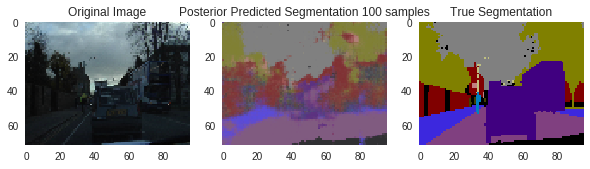

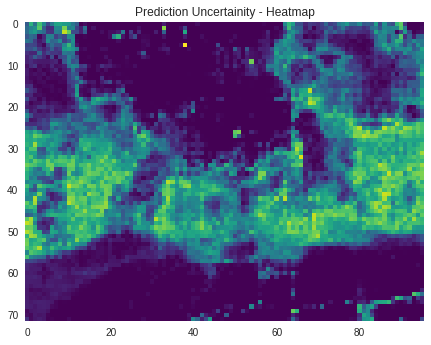

In [17]:
criticism(predicted_mask, latent_dict, test_iterator,NUM_TEST, plot_one_batch_only=True, 
          plot_random_index_per_batch=True)